## Introduction

This Ugrainium recipe uses groupings of ingredients to try to cover nutritional requirements with enough overlap that a single ingredient with quality issues does not cause a failure for the whole recipe. An opimizer is used to find the right amount of each ingredient to fulfill the nutritional and practical requirements.

## To Do

* Nutrients without an upper limit should have the upper limit constraint removed
* Add constraints for the NIH essential protein combinations as a limit
* Add a radar graph for vitamins showing the boundry between RDI and UL
* Add a radar graph for vitamins without an upper limit but showing the RDI
* Add a radar graph for essential proteins showing the range between RDI and UL
* Add a radar graph for essential proteins without an upper limit, but showing the RDI as the lower limit
* Add a radar graph pair for non-essential proteins with the above UL and no UL pairing
* Add equality constraints for at least energy, and macro nutrients if possible

In [12]:
# Import all of the helper libraries 

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import least_squares, lsq_linear, dual_annealing, minimize
import pandas as pd
import numpy as np
import os
import json
from math import e, log, log10
import matplotlib.pyplot as plt
import seaborn as sns
from ipysheet import from_dataframe, to_dataframe

In [13]:
#!pip install seaborn
#!pip install ipysheet
#!pip install ipywidgets

In [14]:
# Setup the notebook context

data_dir = '../src/data'
pd.set_option('max_columns', 70)

# Our Data

The [Google Sheet](https://docs.google.com/spreadsheets/d/1LTF8ydFOspbVOTCmxfqxi_QH-0ByU-Wz4c4Ky2s8A28/edit#gid=1812860789) contains our ingredients and nutrition profile
The sheet names are "Ingredients" and "Nutrition Profile". The links to the sheets are used to load the data as a Pandas data table. The technique to download the sheet data is in the third post of this [Stack Overflow Question](https://stackoverflow.com/questions/33713084/download-link-for-google-spreadsheets-csv-export-with-multiple-sheets)


In [16]:
# Download our nutrition profile data from Google Sheets

# The "Ugrainium PB" spreadsheet
#ingredient_tab_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR46GO190pKxg8hm80NE5mLc2hDKDLJ7ZCLbIuIvx71gikSCI079pYhnljclZ7ltsr4SF_zuPoXCeso/pub?gid=1812860789&single=true&output=csv'
ingredient_tab_url = 'https://docs.google.com/spreadsheets/u/1/d/1LTF8ydFOspbVOTCmxfqxi_QH-0ByU-Wz4c4Ky2s8A28/export?format=csv&id=1LTF8ydFOspbVOTCmxfqxi_QH-0ByU-Wz4c4Ky2s8A28&gid=1812860789'
#nutrition_tab_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR46GO190pKxg8hm80NE5mLc2hDKDLJ7ZCLbIuIvx71gikSCI079pYhnljclZ7ltsr4SF_zuPoXCeso/pub?gid=624419712&single=true&output=csv'
nutrition_tab_url = 'https://docs.google.com/spreadsheets/u/1/d/1LTF8ydFOspbVOTCmxfqxi_QH-0ByU-Wz4c4Ky2s8A28/export?format=csv&id=1LTF8ydFOspbVOTCmxfqxi_QH-0ByU-Wz4c4Ky2s8A28&gid=624419712'
nutrition_profile_df = pd.read_csv(nutrition_tab_url, index_col=0, verbose=True)
for col in ['RDI', 'UL', 'Target Scale', 'Target', 'Weight']:
    nutrition_profile_df[col] = nutrition_profile_df[col].astype(float)
nutrition_profile_df = nutrition_profile_df.transpose()

ingredients_df = pd.read_csv(ingredient_tab_url, index_col=0, verbose=True).transpose()

# convert all values to float
for col in ingredients_df.columns:
    ingredients_df[col] = ingredients_df[col].astype(float)
ingredients_df

Tokenization took: 0.01 ms
Type conversion took: 0.37 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 0.02 ms
Type conversion took: 0.44 ms
Parser memory cleanup took: 0.00 ms


,Calories (kcal),Carbohydrates (g),Protein (g),Total Fat (g),Saturated Fat (g),Monounsaturated Fat (g),Polyunsaturated Fat (g),Omega-3 Fatty Acids (g),Omega-6 Fatty Acids (g),Total Fiber (g),Soluble Fiber (g),Insoluble Fiber (g),Cholesterol (mg),Vitamin A (IU),Vitamin B6 (mg),Vitamin B12 (ug),Vitamin C (mg),Vitamin D (IU),Vitamin E (IU),Vitamin K (ug),Thiamin (mg),Riboflavin (mg),Niacin (mg),Folate (ug),Pantothenic Acid (mg),Biotin (ug),Choline (mg),Calcium (g),Chloride (g),Chromium (ug),Copper (mg),Iodine (ug),Iron (mg),Magnesium (mg),Manganese (mg),Molybdenum (ug),Phosphorus (g),Potassium (g),Selenium (ug),Sodium (g),Sulfur (g),Zinc (mg),Cystine (mg),Histidine (mg),Isoleucine (mg),Leucine (mg),Lysine (mg),Methionine (mg),Phenylalanine (mg),Threonine (mg),Tryptophan (mg),Valine (mg),Tyrosine (mg),Arginine (mg),Alanine (mg),Aspartic acid (mg),Glutamic acid (mg),Glycine (mg),Proline (mg),Serine (mg),Hydroxyproline (mg)
"Wheat bran, crude",216.0,64.51,15.55,4.25,0.630,0.637,2.212,0.167,2.039,42.8,0.00,42.80,0.0,9.0,1.303,0.0,0.0,0.0,1.490,1.9,0.523,0.577,13.578,79.0,2.181,0.0,74.4,0.073,0.000,0.0,0.998,0.0,10.57,611.0,2.000,0.0,1.013,1.182,77.6,0.002,0.605,7.27,371.0,430.0,486.0,928.0,600.0,234.0,595.0,500.0,282.0,726.0,436.0,1087.0,765.0,1130.0,2874.0,898.0,882.0,684.0,0.0
Barley flour,345.0,74.52,10.50,1.60,0.335,0.205,0.771,0.077,0.695,10.1,2.50,7.60,0.0,0.0,0.396,0.0,0.0,0.0,0.570,2.2,0.370,0.114,6.269,8.0,0.145,0.0,37.8,0.032,0.000,0.0,0.343,0.0,2.68,96.0,1.034,0.0,0.296,0.309,37.7,0.004,0.434,2.00,232.0,236.0,383.0,713.0,391.0,202.0,589.0,356.0,175.0,515.0,301.0,526.0,409.0,655.0,2741.0,380.0,1247.0,443.0,0.0
Millet Flour,382.0,75.00,11.00,4.30,0.500,0.924,2.618,0.040,2.550,3.5,1.75,1.75,0.0,0.0,0.372,0.0,0.0,0.0,0.160,0.8,0.413,0.073,6.020,42.0,1.267,0.0,11.2,0.014,0.000,0.0,0.535,0.0,3.94,119.0,1.002,0.0,0.285,0.224,32.7,0.004,0.000,2.63,178.0,257.0,473.0,1537.0,144.0,319.0,675.0,354.0,170.0,584.0,326.0,370.0,1282.0,710.0,2599.0,271.0,911.0,782.0,0.0
"Flaxseed, fresh ground",534.0,31.00,23.00,34.60,3.700,7.500,28.700,22.813,5.911,26.4,13.20,13.20,0.0,0.0,0.500,0.0,0.6,0.0,0.447,4.3,1.600,0.200,3.100,87.0,1.000,0.0,78.7,0.255,0.000,0.0,1.200,0.0,5.70,392.0,2.500,0.0,0.642,0.813,25.4,0.030,0.000,4.30,340.0,472.0,896.0,1235.0,862.0,370.0,957.0,766.0,297.0,1072.0,493.0,1925.0,925.0,2046.0,4038.0,1248.0,806.0,970.0,175.0
Pea Protein Powder,375.0,1.00,82.10,7.14,3.570,0.000,0.000,0.000,0.000,0.5,0.00,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.0,95.0,0.143,0.000,0.0,0.000,0.0,5.79,0.0,0.000,0.0,0.000,0.000,0.0,1.200,0.000,0.00,870.0,2510.0,4760.0,8410.0,7360.0,980.0,5520.0,4050.0,1030.0,5030.0,2810.0,6540.0,3210.0,9110.0,13530.0,3080.0,3380.0,4170.0,0.0
Soy protein isolate,321.0,2.59,88.32,0.53,0.066,0.101,0.258,0.030,0.227,2.0,0.00,0.00,0.0,0.0,0.100,0.0,0.0,0.0,0.000,0.0,0.176,0.100,1.438,176.0,0.060,0.0,190.9,0.178,0.000,0.0,1.599,0.0,14.50,39.0,1.493,0.0,0.776,1.590,0.8,0.050,2.176,4.03,1046.0,2303.0,4253.0,6783.0,5327.0,1130.0,4593.0,3137.0,1116.0,4098.0,3222.0,6670.0,3589.0,10202.0,17451.0,3603.0,4960.0,4594.0,0.0
Whey protein,393.0,6.00,80.00,7.00,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.0,225.0,0.500,0.000,0.0,0.000,0.0,1.20,160.0,0.000,0.0,0.200,0.480,0.0,0.280,0.000,0.00,2089.0,1311.0,5600.0,10200.0,9700.0,1689.0,2579.0,7911.0,1889.0,5879.0,2660.0,1940.0,3660.0,10210.0,15590.0,1650.0,6210.0,4730.0,860.0
Canola oil,884.0,0.00,0.00,100.00,7.365,63.276,28.142,9.137,19.005,0.0,0.00,0.00,0.0,0.0,0.000,0.0,0.0,0.0,17.460,71.3,0.000,0.000,0.000,0.0,0.000,0.0,0.2,0.000,0.000,0.0,0.000,0.0,0.00,0.0,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Multivitamin,0.0,0.00,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.00,0.0,3500.0,2.000,6.0,90.0,400.0,30.000,25.0,1.500,1.700,20.000,500.0,10.000,30.0,0.0,0.200,0.072,35.0,0.900,150.0,18.00,100.0,2.300,45.0,0.109,0

# Problem Setup

Let's cast our data into the from $\vec{y} = A \vec{x} + \vec{b}$ where $A$ is our ingredients data, $\vec{x}$ is the quantity of each ingredient for our recipe, and $\vec{b}$ is the nutrition profile.
The problem to be solved is to find the quantity of each ingredient which will optimally satisfy the nutrition profile, or in our model, to minimize: $|A \vec{x} - \vec{b}|$.

There are some nutrients we only want to track, but not optimize. For example, we want to know how much cholesterol is contained in our recipe, but we don't want to constrain our result to obtain a specific amount of cholesterol as a goal. The full list of ingredients are named: A_full, and b_full. The values to optimized are named: A and b

In [17]:
ingredients_df.shape, nutrition_profile_df.shape

((18, 61), (8, 61))

In [18]:
b_full = nutrition_profile_df
A_full = ingredients_df.transpose()
A = ingredients_df.transpose()[nutrition_profile_df.loc['Report Only'] == False].astype(float)

b_full = nutrition_profile_df.loc['Target']
b = nutrition_profile_df.loc['Target'][nutrition_profile_df.loc['Report Only'] == False].astype(float)
ul = nutrition_profile_df.loc['UL'][nutrition_profile_df.loc['Report Only'] == False].astype(float)
rdi = nutrition_profile_df.loc['RDI'][nutrition_profile_df.loc['Report Only'] == False].astype(float)
weight = nutrition_profile_df.loc['Weight'][nutrition_profile_df.loc['Report Only'] == False]
ul_full = nutrition_profile_df.loc['UL']
rdi_full = nutrition_profile_df.loc['RDI']
A_full.shape

(61, 18)

In [52]:
# Constrain ingredients before the optimization process. Many of the ingredients are required for non-nutritional purposes 
# or are being limited to enhance flavor
#
# The bounds units are in fractions of 100g / day, i.e.: 0.5 represents 50g / day, of the ingredient

#bounds_df = pd.DataFrame(index=ingredients_df.index, data={'lower': 0.0, 'upper': np.inf})
bounds_df = pd.DataFrame(index=ingredients_df.index, data={'lower': 0.0, 'upper': 1.0e6})
bounds_df.loc['Guar gum'] = [1.3 * .01, 1.3 * .01 + .0001]
bounds_df.loc['Xanthan Gum'] = [1.3 * .01, 1.3 * .01 + .0001]
#bounds_df.loc['Alpha-galactosidase enzyme (Beano)'] = [1.0, 1.0 + .0001]
bounds_df.loc['Multivitamin'] = [1.0, 1.0 + .0001]
#bounds_df.loc['Corn flour, nixtamalized'] = [0, 1.0]
bounds_df.loc['Whey protein'] = [0.0,0.15]
bounds_df.loc['Ascorbic acid'] = [0.01, 0.01 + .0001]
#bounds_df.loc['Peanut butter'] = [0.70, 5.0]
bounds_df.loc['Wheat bran, crude'] = [0.25, 5.0]
bounds_df.loc['Flaxseed, fresh ground'] = [0.25, 5.0]
bounds_df.loc['Choline Bitartrate'] = [0.0, 0.05]
bounds_df.loc['Potassium chloride'] = [0.0, 0.07]
bounds_df.loc['Canola oil'] = [0.01, 5.0]  # Minimum amount set to allow mixing of gums, dry pills, and lecithin 
lower = bounds_df.lower.values
upper = bounds_df.upper.values
lower.shape, upper.shape
x0 = pd.array(lower)
bounds = pd.DataFrame( data = {'lower': lower, 'upper': upper}, dtype=float)
bounds.shape, x0.shape
list(zip(lower, upper))
bounds_df

,lower,upper
"Wheat bran, crude",0.25,5.00
Barley flour,0.00,"1,000,000.00"
Millet Flour,0.00,"1,000,000.00"
"Flaxseed, fresh ground",0.25,5.00
Pea Protein Powder,0.00,"1,000,000.00"
Soy protein isolate,0.00,"1,000,000.00"
Whey protein,0.00,0.15
Canola oil,0.01,5.00
Multivitamin,1.00,1.00
Ascorbic acid,0.01,0.01


In [53]:
a = 100.; b = 2.; c = a; k = 10
#a = 20.; b = 2.; c = a; k = 10
a = 5.; b = 0.1 ; c = a; k = 5
#a = 12.; b = 0.1 ; c = 10.; k = 10.
#u0 = (rdi + np.log(rdi)); u0.name = 'u0'
#u0 = rdi * (1 + log(a))
u0 = rdi / (1 - log(k) / a)
u1 = ul / (log(k) / c + 1)
#u1 = ul - np.log(ul); u1.name = 'u1'

# Some objectives are singular without an upper/lower bound
u1.loc[u0 > u1] = (u0 + u1) / 2.0
#u = pd.concat([limits, pd.Series(y0,scale_limits.index, name='y0')], axis=1)

def obj(x):
    y0 = A.dot(x.transpose())
    obj_vec = (np.exp(a * (u0 - y0)/u0) + np.exp(b * (y0 - u0)/u0) + np.nan_to_num(np.exp(c * (y0 - u1)/u1))) * weight
    #print(f'obj_vec: {obj_vec[0]}, y0: {y0[0]}, u0: {u0[0]}')
    return(np.sum(obj_vec))
  
rdi[26], u0[26], u1[26], ul[26]
rdi[0:5], u0[0:5], u1[0:5], ul[0:5]
#np.log(rdi)[26]
#u1
#rdi[u0 > u1], u0[u0 > u1], u1[u0 > u1], ul[u0 > u1]
#u0['Calories (kcal)'], u1['Calories (kcal)']


(Calories (kcal)           1,800.00
 Carbohydrates (g)           260.00
 Protein (g)                  90.00
 Total Fat (g)                60.00
 Omega-3 Fatty Acids (g)       8.50
 Name: RDI, dtype: float64,
 Calories (kcal)           2,654.43
 Carbohydrates (g)           383.42
 Protein (g)                 132.72
 Total Fat (g)                88.48
 Omega-3 Fatty Acids (g)      12.53
 Name: RDI, dtype: float64,
 Calories (kcal)           2,159.36
 Carbohydrates (g)           320.31
 Protein (g)                 111.75
 Total Fat (g)                78.28
 Omega-3 Fatty Acids (g)        NaN
 Name: UL, dtype: float64,
 Calories (kcal)           2,200.00
 Carbohydrates (g)           340.00
 Protein (g)                 120.00
 Total Fat (g)                90.00
 Omega-3 Fatty Acids (g)        NaN
 Name: UL, dtype: float64)

In [54]:
solution = minimize(obj, x0, method='SLSQP', bounds=list(zip(lower, upper)), options = {'maxiter': 10000, 'disp': True, 'ftol': 0.000001})
solution.success

/home/dennis/dev/dunli/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1833.015091658591
            Iterations: 62
            Function evaluations: 1221
            Gradient evaluations: 62


True

In [55]:
x0.shape, A.shape, list(zip(lower, upper))

((18,),
 (38, 18),
 [(0.25, 5.0),
  (0.0, 1000000.0),
  (0.0, 1000000.0),
  (0.25, 5.0),
  (0.0, 1000000.0),
  (0.0, 1000000.0),
  (0.0, 0.15),
  (0.01, 5.0),
  (1.0, 1.0001),
  (0.01, 0.0101),
  (0.0, 1000000.0),
  (0.0, 1000000.0),
  (0.0, 1000000.0),
  (0.0, 0.07),
  (0.013000000000000001, 0.0131),
  (0.013000000000000001, 0.0131),
  (0.0, 0.05),
  (0.0, 1000000.0)])

In [56]:
A_full.dot(solution.x).astype(int)

Calories (kcal)         2383
Carbohydrates (g)        336
Protein (g)              118
Total Fat (g)             81
Saturated Fat (g)          9
                       ...  
Glutamic acid (mg)     23460
Glycine (mg)            4682
Proline (mg)            7778
Serine (mg)             5844
Hydroxyproline (mg)      263
Length: 61, dtype: int64

In [57]:
# Scale the ingredient nutrient amounts for the given quantity of each ingredient given by the optimizer
solution_df = A_full.transpose().mul(solution.x, axis=0) # Scale each nutrient vector per ingredient by the amount of the ingredient
solution_df.insert(0, 'Quantity (g)', solution.x * 100) # Scale to 100 g since that is basis for the nutrient quantities

# Add a row showing the sum of the scaled amount of each nutrient
total = solution_df.sum()
total.name = 'Total'
solution_df = solution_df.append(total)

In [58]:
solution_df['Potassium (g)']

Wheat bran, crude        1.17
Barley flour             0.73
Millet Flour             0.21
Flaxseed, fresh ground   0.63
Pea Protein Powder       0.00
Soy protein isolate      0.00
Whey protein             0.07
Canola oil               0.00
Multivitamin             0.08
Ascorbic acid            0.00
Calcium and vitamin D    0.00
Vitamin K                0.00
Salt, iodized            0.00
Potassium chloride       3.67
Guar gum                 0.00
Xanthan Gum              0.00
Choline Bitartrate       0.00
Lecithin granules        0.08
Total                    6.64
Name: Potassium (g), dtype: float64

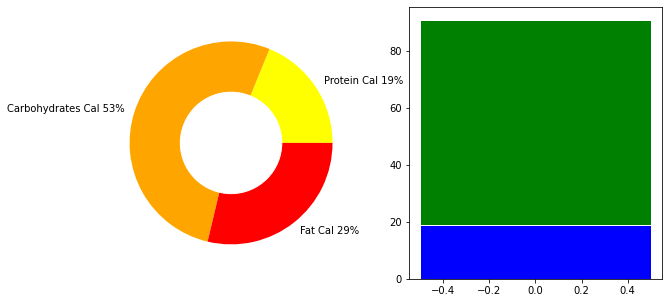

In [59]:
# Plot the macro nutrient profile
# The ratio of Calories for protein:carbohydrates:fat is 4:4:9 kcal/g
pc = solution_df['Protein (g)']['Total'] * 4.0
cc = solution_df['Carbohydrates (g)']['Total'] * 4.0
fc = solution_df['Total Fat (g)']['Total'] * 9.0
tc = pc + cc + fc
p_pct = int(round(pc / tc * 100))
c_pct = int(round(cc / tc * 100))
f_pct = int(round(fc / tc * 100))
(p_pct, c_pct, f_pct)
# create data
names=f'Protein Cal {p_pct}%', f'Carbohydrates Cal {c_pct}%', f'Fat Cal {f_pct}%', 
size=[p_pct, c_pct, f_pct]
 
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1,2,1)
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.5, color='white')

# Give color names
cmap = plt.get_cmap('Spectral')
sm = plt.cm.ScalarMappable(cmap=cmap)
colors = ['yellow','orange','red']
plt.pie(size, labels=names, colors=colors)

#p=plt.gcf()
#p.gca().add_artist(my_circle)
fig.gca().add_artist(my_circle)
#plt.show()

fig.add_subplot(1,2,2)
barWidth = 1
fs = [solution_df['Soluble Fiber (g)']['Total']]
fi = [solution_df['Insoluble Fiber (g)']['Total']]
plt.bar([0], fs, color='blue', edgecolor='white', width=barWidth, label=['Soluble Fiber (g)'])
plt.bar([0], fi, bottom=fs, color='green', edgecolor='white', width=barWidth, label=['Insoluble Fiber (g)'])
plt.show()
# Also show the Omega-3, Omega-6 ratio
# Saturated:Monounsaturated:Polyunsaturated ratios

In [60]:
# Prepare data as a whole for plotting by normalizing and scaling
amounts = solution_df
total = A_full.dot(solution.x) #solution_df.loc['Total']

# Normalize as a ratio beyond RDI
norm = (total) / rdi_full
norm_ul = (ul_full) / rdi_full

nuts = pd.concat([pd.Series(norm.values, name='value'), pd.Series(norm.index, name='name')], axis=1)
norm['Potassium (g)']


1.4118070440580126

In [61]:
# Setup categories of nutrients and a common plotting function
vitamins = ['Vitamin A (IU)','Vitamin B6 (mg)','Vitamin B12 (ug)','Vitamin C (mg)','Vitamin D (IU)',
            'Vitamin E (IU)','Vitamin K (ug)','Thiamin (mg)','Riboflavin (mg)','Niacin (mg)','Folate (ug)','Pantothenic Acid (mg)','Biotin (ug)','Choline (mg)']
minerals = ['Calcium (g)','Chloride (g)','Chromium (ug)','Copper (mg)','Iodine (ug)','Iron (mg)',
            'Magnesium (mg)','Manganese (mg)','Molybdenum (ug)','Phosphorus (g)','Potassium (g)','Selenium (ug)','Sodium (g)','Sulfur (g)','Zinc (mg)']
essential_aminoacids = ['Cystine (mg)','Histidine (mg)','Isoleucine (mg)','Leucine (mg)','Lysine (mg)',
                        'Methionine (mg)','Phenylalanine (mg)','Threonine (mg)','Tryptophan (mg)','Valine (mg)']
other_aminoacids = ['Tyrosine (mg)','Arginine (mg)','Alanine (mg)','Aspartic acid (mg)','Glutamic acid (mg)','Glycine (mg)','Proline (mg)','Serine (mg)','Hydroxyproline (mg)']

def plot_group(nut_names, title):
    nut_names_short = [s.split(' (')[0] for s in nut_names] # Snip off the units from the nutrient names
    
    # Create a bar to indicate an upper limit 
    ul_bar = (norm_ul * 1.04)[nut_names]
    ul_bar[ul_full[nut_names].isnull() == True] = 0
    
    # Create a bar to mask the UL bar so just the end is exposed
    ul_mask = norm_ul[nut_names]
    ul_mask[ul_full[nut_names].isnull() == True] = 0
    
    
    n = []  # normalized values for each bar
    for x, mx in zip(norm[nut_names], ul_mask.values):
        if mx == 0: # no upper limit
            if x < 1.0:
                n.append(1.0 - (x / 2.0))
            else:
                n.append(0.50)
        else:
            n.append(1.0 - (log10(x) / log10(mx)))
    clrs = sm.to_rgba(n, norm=False)
    
    g = sns.barplot(x=ul_bar.values, y=nut_names_short, color='red')
    g.set_xscale('log')
    sns.barplot(x=ul_mask.values, y=nut_names_short, color='white')
    bax = sns.barplot(x=norm[nut_names], y=nut_names_short, label="Total", palette=clrs)
    
    # Add a legend and informative axis label
    g.set( ylabel="",xlabel="Nutrient Mass / RDI (Red Band is UL)", title=title)

    #sns.despine(left=True, bottom=True)

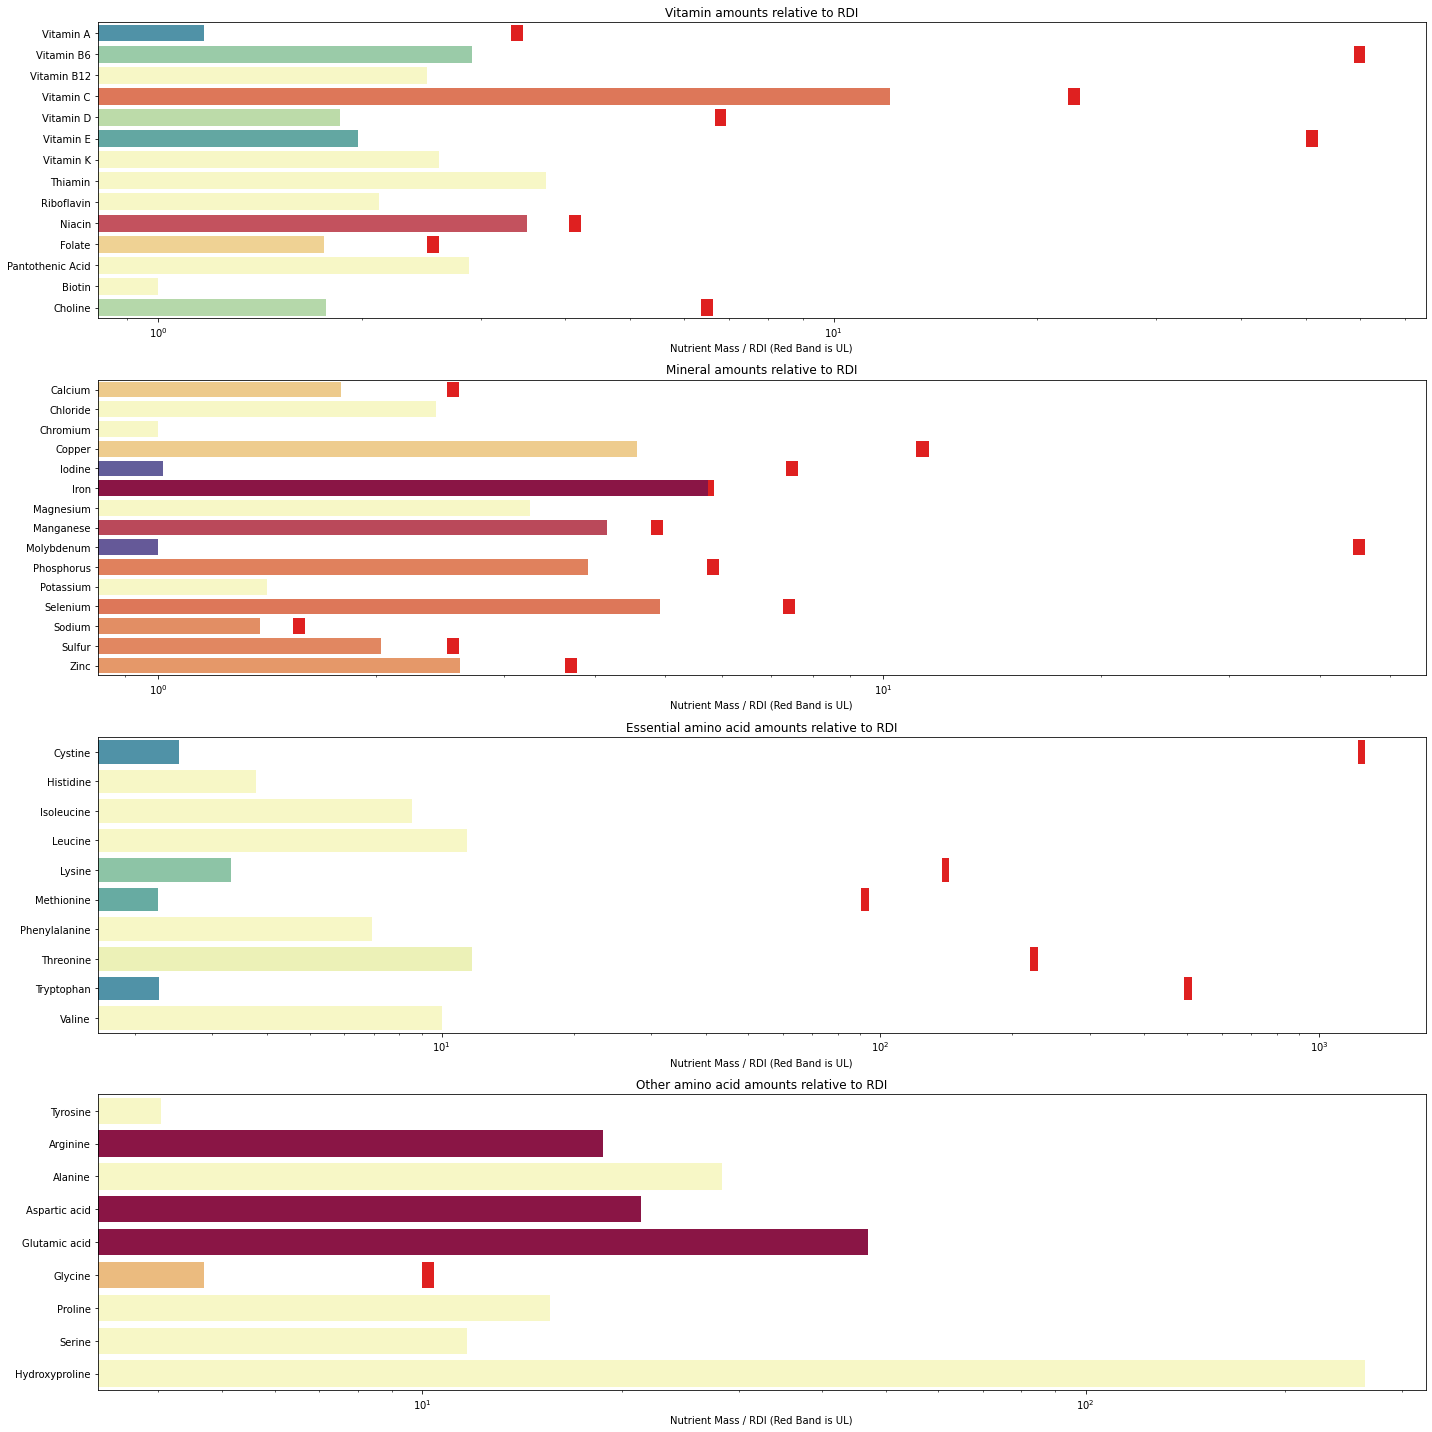

In [62]:
# Construct a group of bar charts for each nutrient group

# Setup the colormap for each bar
cmap = plt.get_cmap('Spectral')
sm = plt.cm.ScalarMappable(cmap=cmap)

#fig = plt.figure(figsize=plt.figaspect(3.))
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(4, 1, 1)
plot_group(vitamins,'Vitamin amounts relative to RDI')
fig.add_subplot(4, 1, 2)
plot_group(minerals,'Mineral amounts relative to RDI')
fig.add_subplot(4, 1, 3)
plot_group(essential_aminoacids,'Essential amino acid amounts relative to RDI')
fig.add_subplot(4, 1, 4)
plot_group(other_aminoacids,'Other amino acid amounts relative to RDI')

#fig.show()
fig.tight_layout()

In [63]:
#solu_amount = (solution_df['Quantity (g)'] * 14).astype(int)
pd.options.display.float_format = "{:,.2f}".format
solu_amount = solution_df['Quantity (g)']
solu_amount.index.name = 'Ingredient'
#solu_amount['Batch (g)'] = solu_amount * 14.0
solu_amount.reset_index()
recipe = pd.DataFrame(solu_amount)
recipe['Batch (g)'] = recipe['Quantity (g)'] * 14.0
recipe

,Quantity (g),Batch (g)
Ingredient,,
"Wheat bran, crude",99.26,"1,389.68"
Barley flour,235.48,"3,296.68"
Millet Flour,91.68,"1,283.46"
"Flaxseed, fresh ground",77.06,"1,078.87"
Pea Protein Powder,46.72,654.03
Soy protein isolate,0.00,0.00
Whey protein,15.00,210.00
Canola oil,35.90,502.56
Multivitamin,100.01,"1,400.14"


In [49]:
A_full.dot(solution.x).astype(int)['Calories (kcal)']

2384

In [50]:
recipe['Quantity (g)']['Total']

961.973563709121

In [51]:
calories = A_full.dot(solution.x).astype(int)['Calories (kcal)']
weight = recipe['Quantity (g)']['Total'] - recipe['Quantity (g)']['Vitamin K'] - recipe['Quantity (g)']['Alpha-galactosidase enzyme (Beano)'] - recipe['Quantity (g)']['Multivitamin'] - recipe['Quantity (g)']['Calcium and vitamin D'] 
cal_by_100g = int(calories / weight * 100.)
'Calories per 100 g:', cal_by_100g

KeyError: 'Alpha-galactosidase enzyme (Beano)'

In [46]:
'Volume of 1/7 of pitcher:', 2000 / 7

('Volume of 1/7 of pitcher:', 285.7142857142857)

In [67]:
meal = pd.DataFrame.from_dict({'Calories (kcal)': range(1000, 2600, 100)})
meal['Measure (g)'] = round(meal['Calories (kcal)'] / cal_by_100g * 100)
print('Amount to measure daily for calorie goal: ')
meal

NameError: name 'cal_by_100g' is not defined